<a href="https://colab.research.google.com/github/BAgaoglu/black-or-brown/blob/main/blackorbrown.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
ls /content/drive/MyDrive/bear_images

black_images/  brown_images/


In [ ]:
import os

num_skipped = 0
for folder_name in ("/content/drive/MyDrive/bear_images/black_images/data/train", "/content/drive/MyDrive/bear_images/brown_images/data/train"):
    folder_path = os.path.join("/content/drive/MyDrive/bear_images", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


In [ ]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/bear_images",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/bear_images",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 2692 files belonging to 2 classes.
Using 2154 files for training.
Found 2692 files belonging to 2 classes.
Using 538 files for validation.


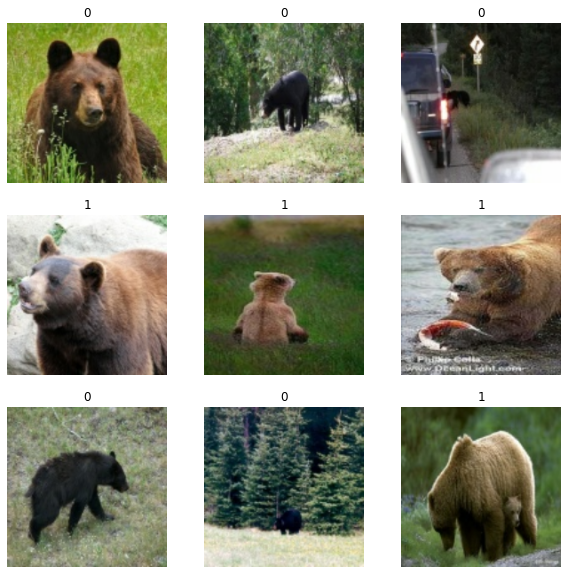

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

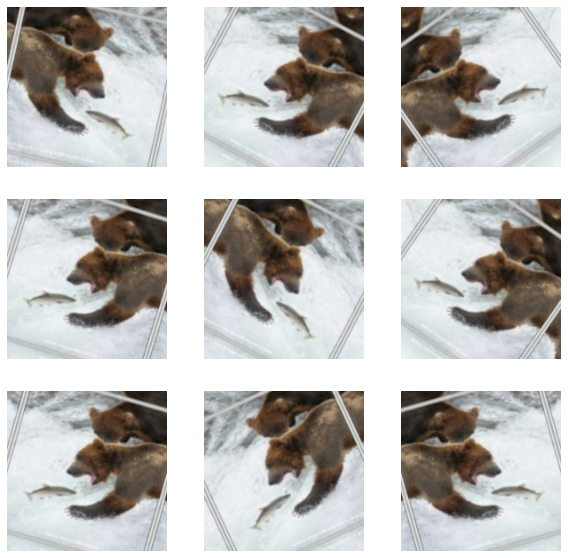

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

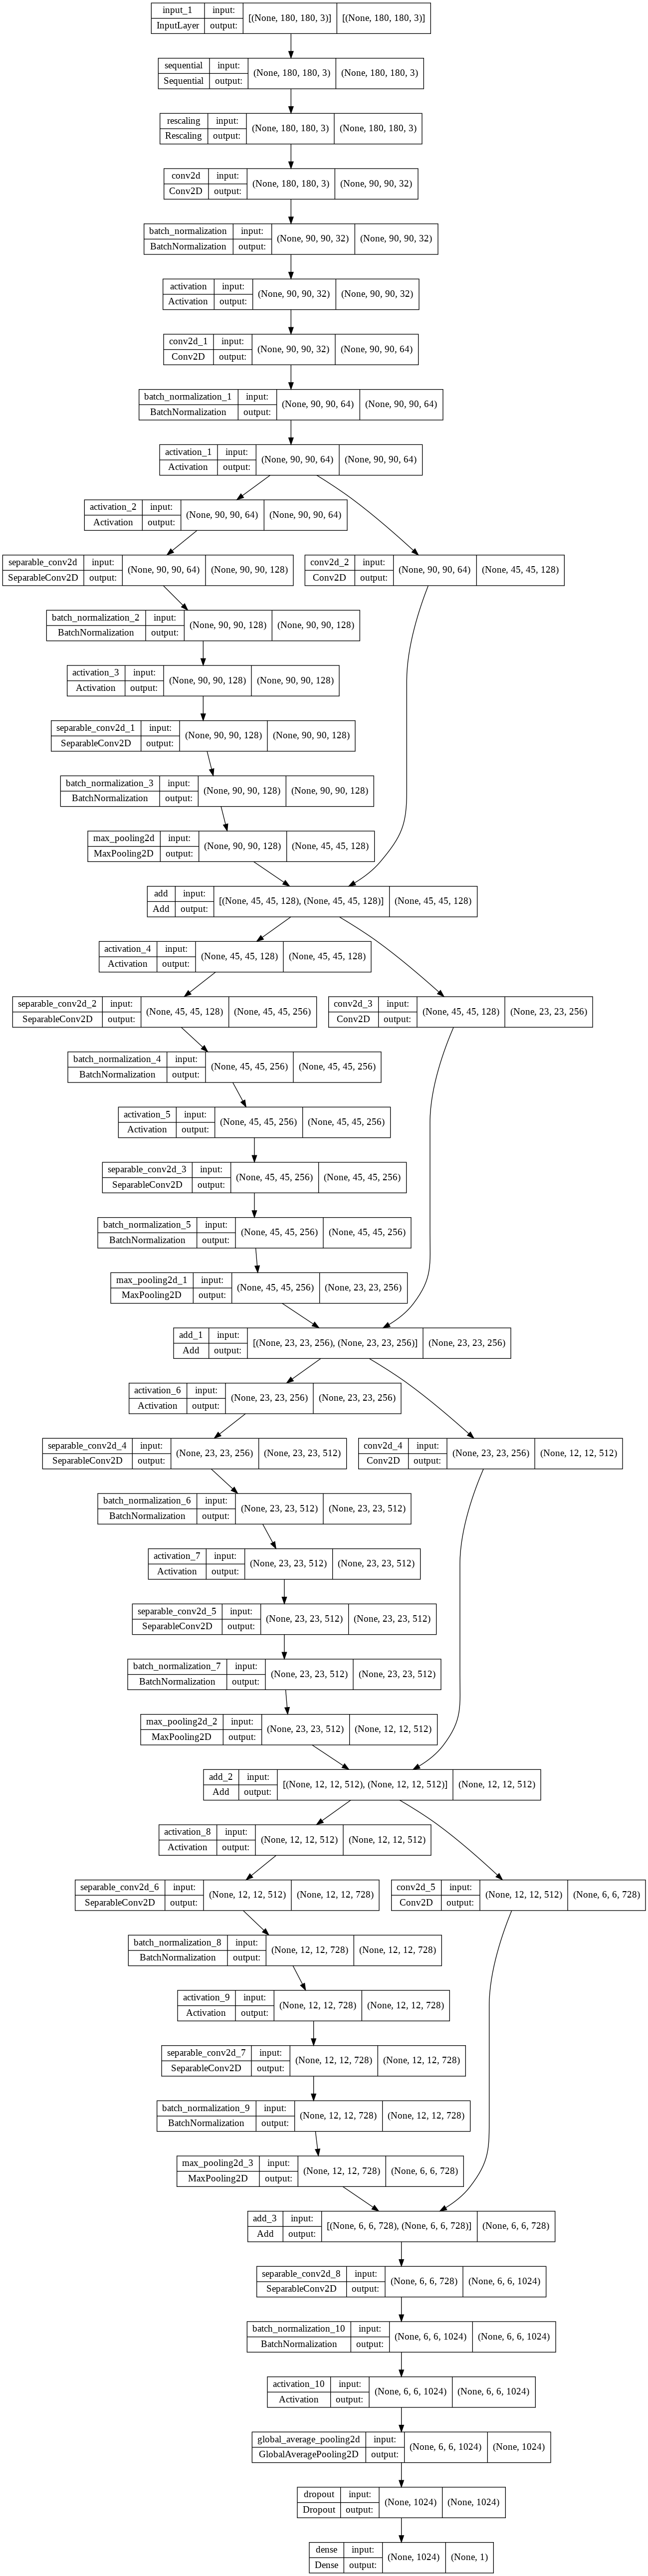

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epochs = 20

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/20
68/68 [==============================] - 584s 9s/step - loss: 0.5569 - accuracy: 0.7344 - val_loss: 0.6926 - val_accuracy: 0.5390
Epoch 2/20
68/68 [==============================] - 552s 8s/step - loss: 0.4101 - accuracy: 0.8134 - val_loss: 0.7246 - val_accuracy: 0.5390
Epoch 3/20
68/68 [==============================] - 564s 8s/step - loss: 0.3607 - accuracy: 0.8431 - val_loss: 0.7304 - val_accuracy: 0.5390
Epoch 4/20
68/68 [==============================] - 566s 8s/step - loss: 0.3740 - accuracy: 0.8431 - val_loss: 0.7753 - val_accuracy: 0.5390
Epoch 5/20
68/68 [==============================] - 567s 8s/step - loss: 0.3358 - accuracy: 0.8556 - val_loss: 0.6902 - val_accuracy: 0.5204
Epoch 6/20
68/68 [==============================] - 576s 8s/step - loss: 0.3349 - accuracy: 0.8533 - val_loss: 0.7433 - val_accuracy: 0.4814
Epoch 7/20
68/68 [==============================] - 600s 9s/step - loss: 0.3028 - accuracy: 0.8765 - val_loss: 0.5094 - val_accuracy: 0.7565
Epoch 8/20
68

In [ ]:
img = keras.preprocessing.image.load_img(
    "/content/20130607_Bow-copy.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent black bear and %.2f percent brown bear."
    % (100 * (1 - score), 100 * score)
)

This image is 99.88 percent black bear and 0.12 percent brown bear.
